In [1]:
import pandas as pd

# Préparation de l’environnement :
# Import des librairies nécessaires avant modélisation.
# ------------------------------------------------------------

# Chargement des données brutes :
# Lecture des 3 datasets fournis par le département RH.
# ------------------------------------------------------------

sirh = pd.read_csv("../data/sirh.csv")
perf = pd.read_csv("../data/performance.csv")
survey = pd.read_csv("../data/survey.csv")

# Nettoyage des colonnes :
# Uniformisation des noms pour éviter erreurs lors des jointures.
# ------------------------------------------------------------

sirh.columns = sirh.columns.str.lower().str.strip()
perf.columns = perf.columns.str.lower().str.strip()
survey.columns = survey.columns.str.lower().str.strip()

# Création du DataFrame central :
# Fusion INNER pour ne garder que les employés présents dans les 3 sources.
# ------------------------------------------------------------

df = (
    sirh
    .merge(perf, on="employee_id", how="inner")
    .merge(survey, on="employee_id", how="inner")
)

df.head()



,employee_id,age,salary,tenure_years,department,gender,job_level,performance_score,manager_rating,satisfaction_global,work_life_balance,engagement_score,stress_level,has_left
0,1,28,38000,1.2,IT,F,Junior,3.2,3.0,2.5,2.8,3.0,4.2,1
1,2,34,45000,3.5,Finance,M,Intermediate,4.1,4.0,3.8,3.5,4.0,2.1,0
2,3,42,52000,6.8,HR,F,Senior,4.8,5.0,4.5,4.2,4.8,1.9,0
3,4,31,40000,2.0,IT,M,Junior,3.0,2.8,2.9,2.7,3.0,3.9,1
4,5,26,36000,0.8,Marketing,F,Junior,2.5,2.0,2.3,2.1,2.5,4.5,1


In [2]:
# Identification des variables pertinentes :
# ------------------------------------------------------------

target = "has_left"

num_cols = ["age", "salary", "tenure_years", "satisfaction_global", "stress_level"]
cat_cols = ["department", "gender", "job_level"]

X = df[num_cols + cat_cols]
y = df[target]


In [3]:
from sklearn.model_selection import train_test_split

# ⚠️ Remarque méthodologique :
# Le dataset est de petite taille, ce qui limite la robustesse statistique.
# La stratification est néanmoins conservée afin de respecter la distribution des classes.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((8, 8), (2, 8))

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Préparation des données pour modélisation :
# Pipelines séparés pour numérique et catégoriel.
# ------------------------------------------------------------

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)



c:\Users\selma\Desktop\Technovaa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\selma\Desktop\Technovaa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\selma\Desktop\Technovaa\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



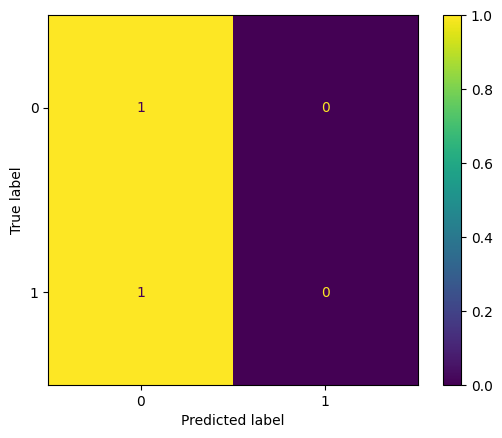

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Modèle étalon :
# Référence minimale à dépasser.
# ------------------------------------------------------------

dummy = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DummyClassifier(strategy="most_frequent"))
])

dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print(classification_report(y_test, y_pred_dummy))

cm = confusion_matrix(y_test, y_pred_dummy)
ConfusionMatrixDisplay(cm).plot()



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

AUC : 1.0


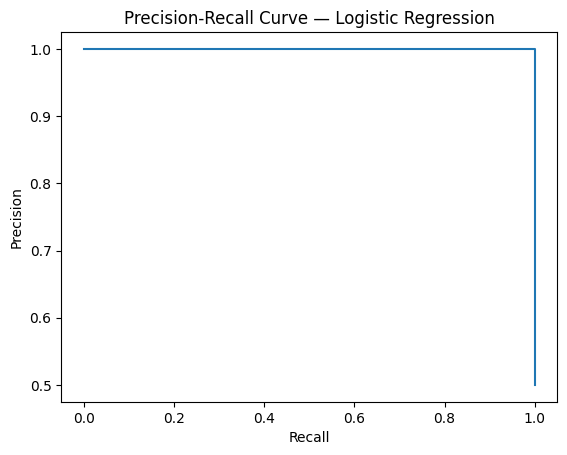

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# Modèle linéaire interprétable :
# ------------------------------------------------------------

logreg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))
print("AUC :", roc_auc_score(y_test, y_proba_lr))

# Courbe Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_lr)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Logistic Regression")
plt.show()



In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

# Modèle non linéaire avec gestion du déséquilibre :
# ------------------------------------------------------------

rf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(k_neighbors=1, random_state=42)),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Choix d’un seuil à 0.5 par défaut.
# En contexte réel, il serait ajusté selon le coût métier
# d’un faux négatif (départ non anticipé).
y_pred_rf = (y_proba_rf >= 0.5).astype(int)

print(classification_report(y_test, y_pred_rf))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate

pipe_rf = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(k_neighbors=1, random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleure AUC :", grid.best_score_)

# Moyenne et écart-type des performances
cv_results = cross_validate(
    grid.best_estimator_,
    X_train,
    y_train,
    cv=cv,
    scoring="roc_auc"
)

print("AUC moyenne :", cv_results["test_score"].mean())
print("Écart-type AUC :", cv_results["test_score"].std())



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Meilleurs paramètres : {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Meilleure AUC : 1.0
AUC moyenne : 1.0
Écart-type AUC : 0.0


In [9]:
import shap
import numpy as np

# Préparation des données pour l’interprétabilité :
# ------------------------------------------------------------

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

if hasattr(X_train_pre, "toarray"):
    X_train_pre = X_train_pre.toarray()
    X_test_pre = X_test_pre.toarray()

feature_names = preprocessor.get_feature_names_out()




c:\Users\selma\Desktop\Technovaa\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


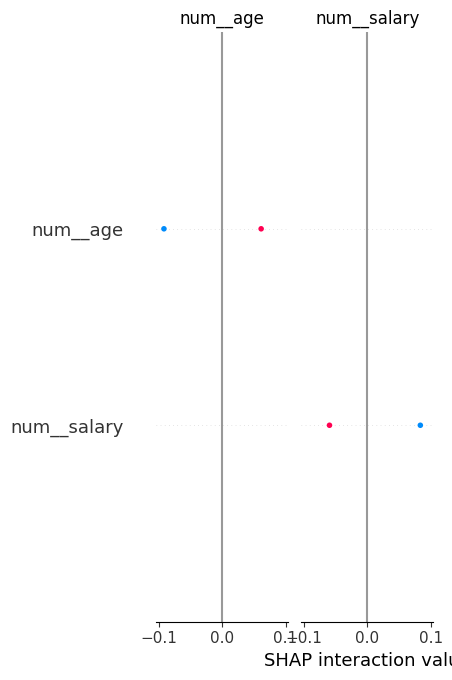

In [10]:
# Interprétation globale du modèle :
# Les variables ayant les valeurs SHAP les plus élevées
# sont celles qui influencent le plus le départ des employés.

rf_shap = RandomForestClassifier(n_estimators=200, random_state=42)
rf_shap.fit(X_train_pre, y_train)

explainer = shap.Explainer(rf_shap, X_train_pre, feature_names=feature_names)
shap_values = explainer(X_test_pre)

shap.summary_plot(
    shap_values.values,
    X_test_pre,
    feature_names=feature_names,
    plot_type="dot"
)


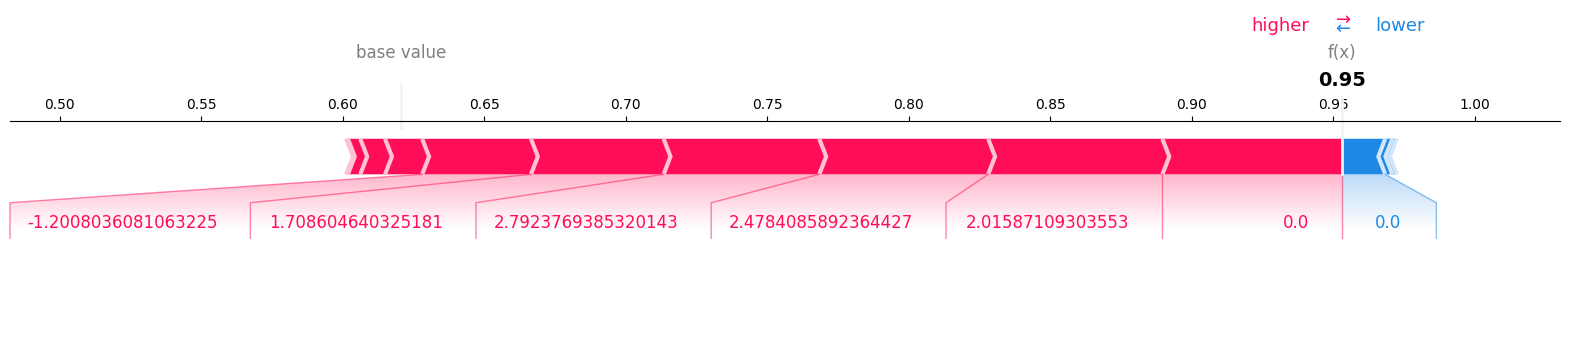

In [11]:
idx = 0  # individu analysé

base_value = explainer.expected_value
shap_val = shap_values.values

if isinstance(base_value, (list, np.ndarray)):
    base_value = base_value[0]

if shap_val.ndim == 3:
    shap_val = shap_val[:, :, 0]

# Force plot stable (matplotlib)
shap.plots.force(
    base_value,
    shap_val[idx],
    X_test_pre[idx],
    matplotlib=True
)
